In [173]:
import astropy
from astropy.io import fits
import numpy
from numpy import *
import matplotlib as mpl
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import yt
from scipy.signal import find_peaks

%matplotlib inline

In [174]:
ds = yt.load('/Users/rsimons/Dropbox/rcs_foggie/data/halo_008508/nref11n_selfshield_z15/DD0600/DD0600')

yt : [INFO     ] 2018-11-13 14:12:39,334 Parameters: current_time              = 183.066527818
yt : [INFO     ] 2018-11-13 14:12:39,335 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-11-13 14:12:39,337 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2018-11-13 14:12:39,338 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2018-11-13 14:12:39,340 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-11-13 14:12:39,342 Parameters: current_redshift          = 1.67203863787
yt : [INFO     ] 2018-11-13 14:12:39,343 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2018-11-13 14:12:39,345 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2018-11-13 14:12:39,346 Parameters: hubble_constant           = 0.695


In [175]:
anchor_xs_box_avg = 26564.85890163585
anchor_ys_box_avg = 26236.47388230963
anchor_zs_box_avg = 27090.86022165454
cen = yt.YTArray([anchor_xs_box_avg, anchor_ys_box_avg, anchor_zs_box_avg], 'kpc')


In [176]:
rad = 5

In [177]:
gc_sphere =  ds.sphere(cen, ds.arr(rad, 'kpc'))

Parsing Hierarchy : 100%|██████████| 1177/1177 [00:00<00:00, 25556.89it/s]
yt : [INFO     ] 2018-11-13 14:12:42,094 Gathering a field list (this may take a moment.)


In [178]:
def _stars(pfilter, data):
    return data[(pfilter.filtered_type, "particle_type")] == 2


def _youngstars(pfilter, data):
    return data[(pfilter.filtered_type, "age")] < 2.e7


# these are only the must refine dark matter particles
def _darkmatter(pfilter, data):
    return data[(pfilter.filtered_type, "particle_type")] == 4





yt.add_particle_filter("stars",function=_stars, filtered_type='all',requires=["particle_type"])
yt.add_particle_filter("youngstars",function=_youngstars, filtered_type='all',requires=["age"])
yt.add_particle_filter("darkmatter",function=_darkmatter, filtered_type='all',requires=["particle_type"])

ds.add_particle_filter('stars')
ds.add_particle_filter('darkmatter')
ds.add_particle_filter('youngstars')



True

In [179]:
DM_mass = gc_sphere.quantities.total_quantity([("darkmatter", "particle_mass")]).to('Msun')
gas_mass = gc_sphere.quantities.total_quantity([("gas", "cell_mass")])
gas_metal_mass = gc_sphere.quantities.total_quantity([("gas", "metal_mass")])

stars_mass = gc_sphere.quantities.total_quantity([("stars", "particle_mass")])
youngstars_mass = gc_sphere.quantities.total_quantity([("youngstars", "particle_mass")])





In [180]:
DDnum = 350
#DDnum = 600

a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_selfshield_z15_DD%.4i_momentum.fits'%DDnum)
#a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_selfshield_z15_DD0600_momentum.fits')
#a = fits.open('/Users/rsimons/Dropbox/rcs_foggie/outputs/momentum_fits/nref11n_nref10f_selfshield_z6_DD0600_momentum.fits')

In [181]:
ms_s = a['STAR_MASS'].data
age_s = a['STAR_AGE'].data

id_s = a['STARS_ID'].data
rd_s = sqrt(sum(a['STARS_GAL_POSITION'].data**2., axis = 0))
x_s, y_s, z_s = a['STARS_GAL_POSITION'].data
vx_s, vy_s, vz_s = a['STARS_GAL_VELOCITY'].data

x_s_box, y_s_box, z_s_box = a['STARS_BOX_POSITION'].data
vx_s_box, vy_s_box, vz_s_box = a['STARS_BOX_VELOCITY'].data



ep_s = a['STARS_EPSILON_FIXED'].data

ms_d = a['DARK_MASS'].data
rd_d = sqrt(sum(a['DARK_GAL_POSITION'].data**2., axis = 0))
x_d, y_d, z_d = a['DARK_GAL_POSITION'].data
vx_d, vy_d, vz_d = a['DARK_GAL_VELOCITY'].data

ep_d = a['DARK_EPSILON_FIXED'].data



In [182]:
xmn, xmx = 0, 150
jmn, jmx = -2, 2

bns = 500

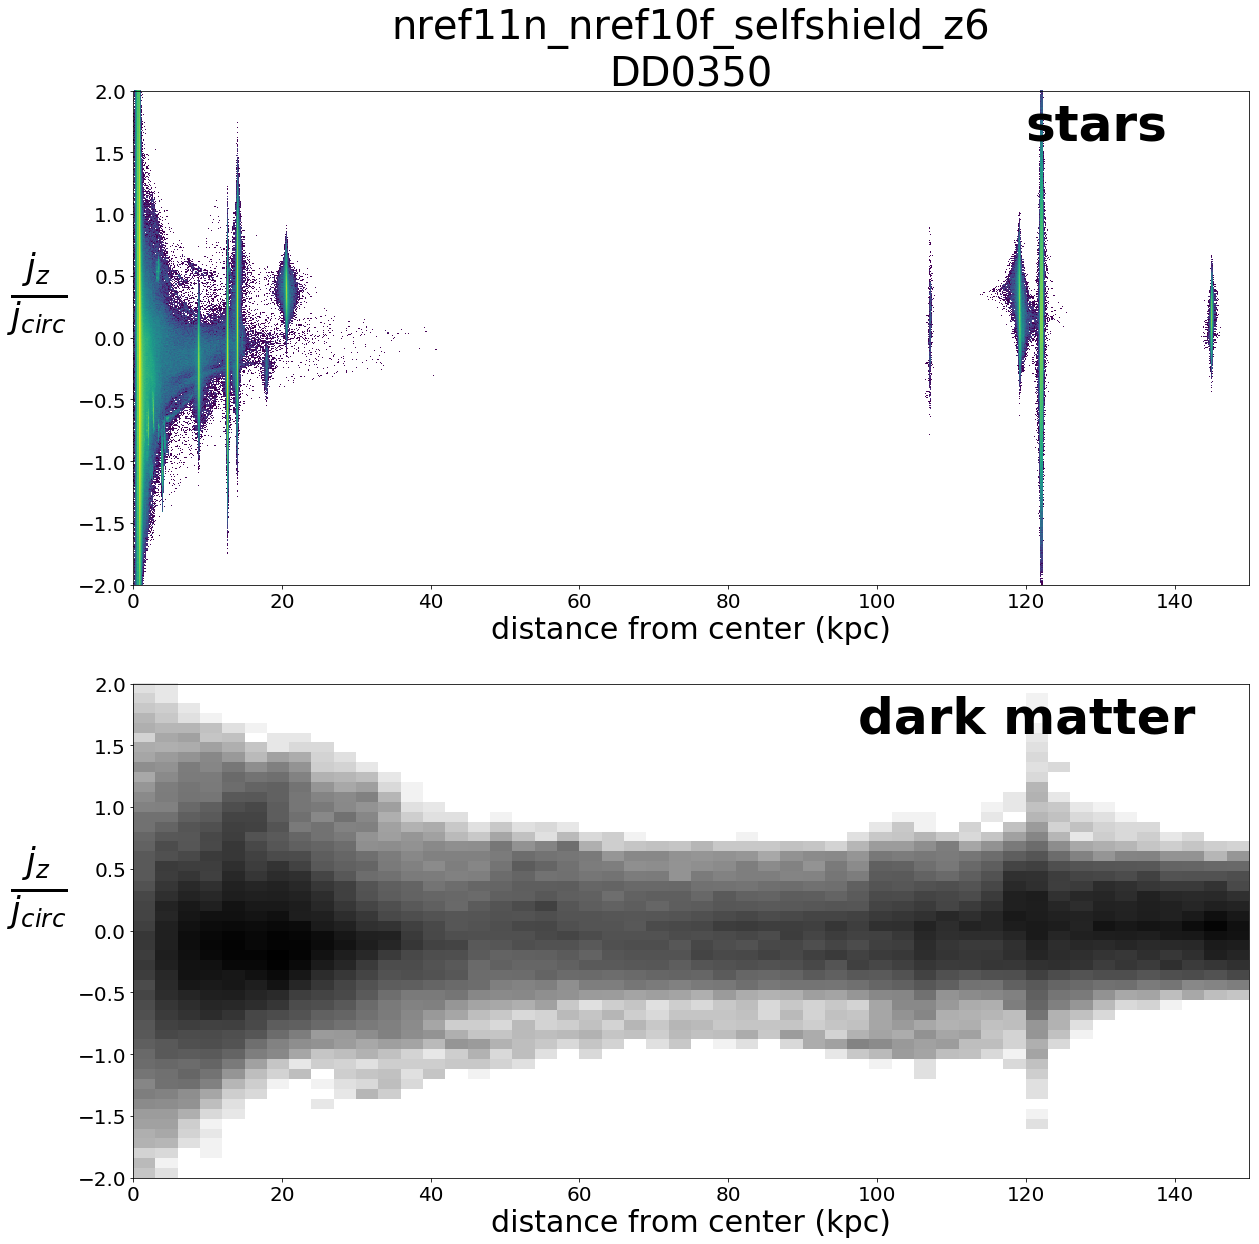

In [183]:
fig, axes = plt.subplots(2,1, figsize = (20,20))




axes[0].hist2d(rd_s, ep_s, range = ([xmn, xmx], [jmn, jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = 1000)
axes[1].hist2d(rd_d, ep_d, range = ([xmn, xmx], [jmn, jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.Greys, bins = 50)

axes[0].set_title('nref11n_nref10f_selfshield_z6\nDD%.4i'%DDnum, fontsize = 40)
axes[0].annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
axes[1].annotate('dark matter', (0.65, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')


for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('distance from center (kpc)', fontsize = 30)
    ax.set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)


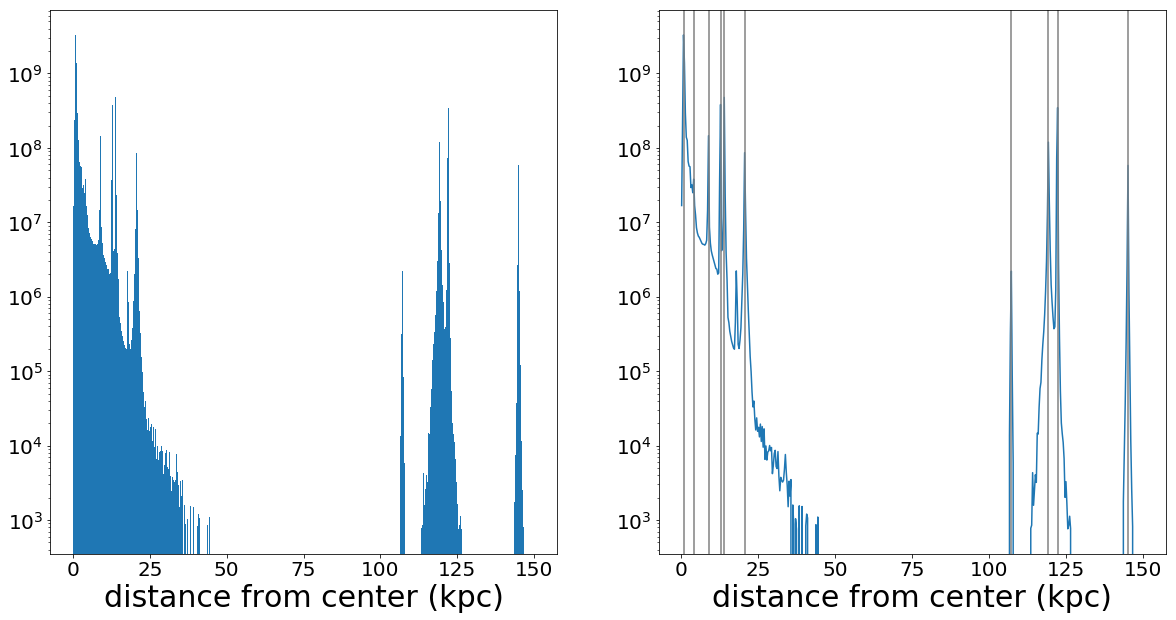

In [184]:
fig, axes = plt.subplots(1,2, figsize = (20,10))

hst, edges = histogram(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))

rds = np.mean([edges[0:len(edges) - 1], edges[1:len(edges)]], axis = 0)


axes[0].hist(rd_s, weights = ms_s, bins = linspace(0, xmx, bns))
axes[1].plot(rds, hst)




peaks, _ = find_peaks(hst, distance = 1.*bns/(xmx-xmn), threshold = 1.e6/(0.2*bns/(xmx-xmn)))

for p in peaks:
    axes[1].axvline(rds[p], color = 'grey')
    


for ax in axes:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('distance from center (kpc)', fontsize = 30)

    
    
    

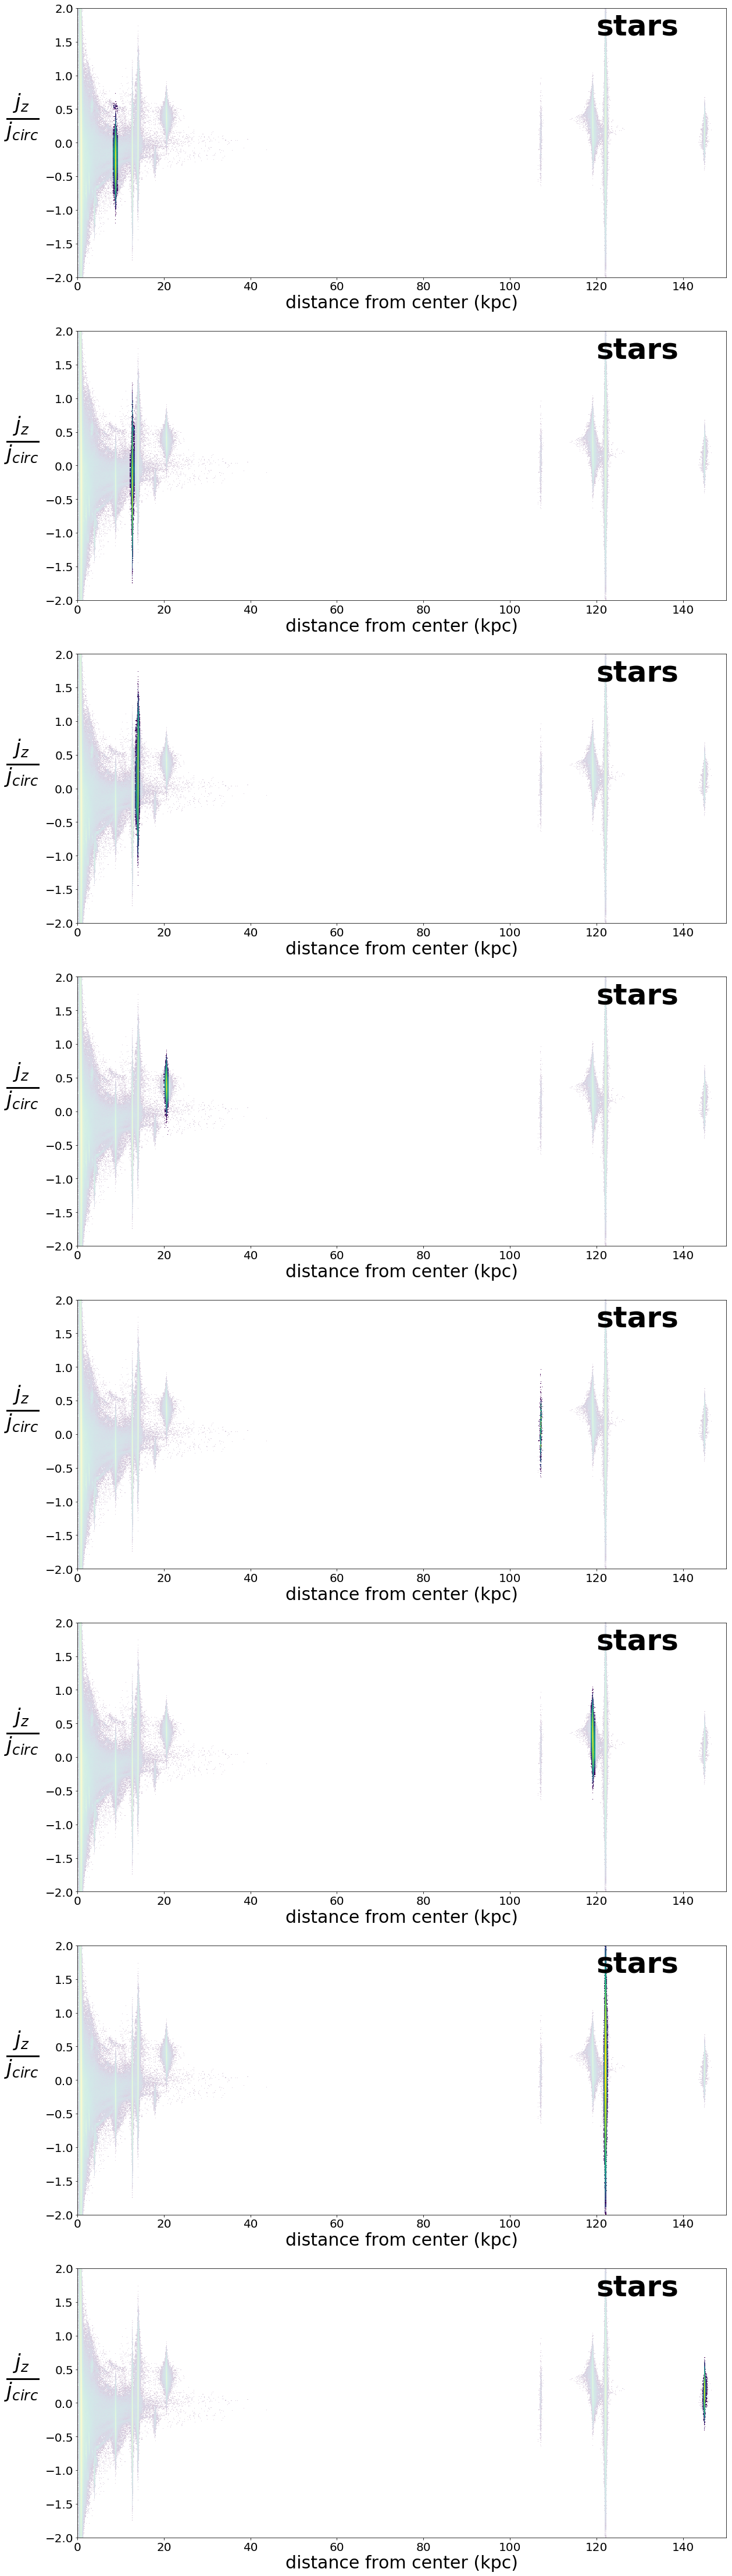

In [186]:

peaks_use = peaks[2:len(peaks)]

fig, axes = plt.subplots(len(peaks_use), 1, figsize = (20,10*len(peaks_use)))



bns_2d = 1000


for i,p in enumerate(peaks_use):

    mn_r = rds[p] - 0.5
    mx_r = rds[p] + 0.5

    in_sel = (rd_s > mn_r) & (rd_s < mx_r)
    in_sel_age = (rd_s > mn_r) & (rd_s < mx_r) & (age_s > 2.e9)

    axes[i].hist2d(rd_s, ep_s, range = ([xmn, xmx], [jmn,jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = bns_2d, alpha = 0.2)

    axes[i].hist2d(rd_s[in_sel], ep_s[in_sel], range = ([xmn, xmx], [jmn,jmx]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = bns_2d)



    axes[i].annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    axes[i].set_xlabel('distance from center (kpc)', fontsize = 30)
    axes[i].set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)




In [188]:
len(peaks)

10

In [9]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    # Fast and numerically precise:
    variance = numpy.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

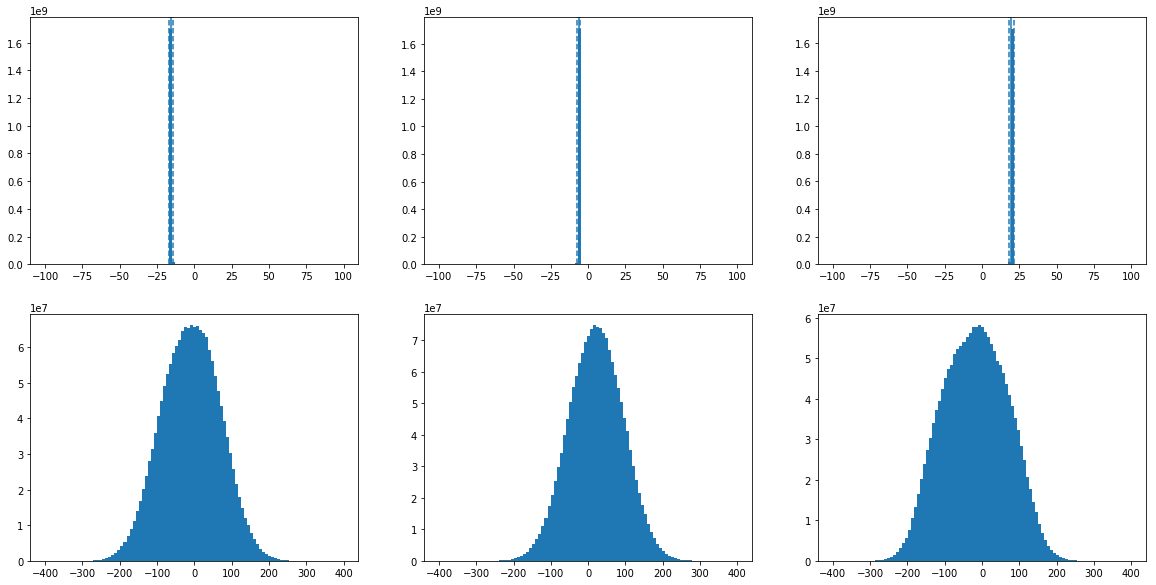

In [10]:
fig, axes = plt.subplots(2,3, figsize = (20, 10))

x_s_avg, x_s_std = weighted_avg_and_std(x_s[in_sel], weights = ms_s[in_sel])
y_s_avg, y_s_std = weighted_avg_and_std(y_s[in_sel], weights = ms_s[in_sel])
z_s_avg, z_s_std = weighted_avg_and_std(z_s[in_sel], weights = ms_s[in_sel])



x_hist = axes[0,0].hist(x_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))
y_hist = axes[0,1].hist(y_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))
z_hist = axes[0,2].hist(z_s[in_sel], weights = ms_s[in_sel], bins = linspace(-100, 100, 100))


axes[0,0].axvline(x = x_s_avg)
axes[0,0].axvline(x = x_s_avg + x_s_std, linestyle = 'dashed')
axes[0,0].axvline(x = x_s_avg - x_s_std, linestyle = 'dashed')

axes[0,1].axvline(x = y_s_avg)
axes[0,1].axvline(x = y_s_avg + y_s_std, linestyle = 'dashed')
axes[0,1].axvline(x = y_s_avg - y_s_std, linestyle = 'dashed')

axes[0,2].axvline(x = z_s_avg)
axes[0,2].axvline(x = z_s_avg + z_s_std, linestyle = 'dashed')
axes[0,2].axvline(x = z_s_avg - z_s_std, linestyle = 'dashed')


vx_hist = axes[1,0].hist(vx_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))
vy_hist = axes[1,1].hist(vy_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))
vz_hist = axes[1,2].hist(vz_s[in_sel], weights = ms_s[in_sel], bins = linspace(-400, 400, 100))





In [11]:
good       = where((abs(x_s[in_sel] - x_s_avg) < 3 * x_s_std) & 
                   (abs(y_s[in_sel] - y_s_avg) < 3 * y_s_std) & 
                   (abs(z_s[in_sel] - z_s_avg) < 3 * z_s_std))[0]

good_ids  = id_s[in_sel][good]
good_ages = age_s[in_sel][good]
good_rds = rd_s[in_sel][good]
good_eps = ep_s[in_sel][good]
good_mss = ms_s[in_sel][good]
good_xs = x_s[in_sel][good]
good_ys = y_s[in_sel][good]
good_zs = z_s[in_sel][good]
good_vxs = vx_s[in_sel][good]
good_vys = vy_s[in_sel][good]
good_vzs = vz_s[in_sel][good]

good_xs_box = x_s_box[in_sel][good]
good_ys_box = y_s_box[in_sel][good]
good_zs_box = z_s_box[in_sel][good]
good_vxs_box = vx_s_box[in_sel][good]
good_vys_box = vy_s_box[in_sel][good]
good_vzs_box = vz_s_box[in_sel][good]






anchor_ids  = good_ids[argsort(good_ages)[::-1][0:1000]].astype('int')
anchor_ages = good_ages[argsort(good_ages)[::-1][0:1000]]
anchor_rds  = good_rds[argsort(good_ages)[::-1][0:1000]]
anchor_eps  = good_eps[argsort(good_ages)[::-1][0:1000]]
anchor_mss  = good_mss[argsort(good_ages)[::-1][0:1000]]

anchor_xs    = good_xs[argsort(good_ages)[::-1][0:1000]]
anchor_ys    = good_ys[argsort(good_ages)[::-1][0:1000]]
anchor_zs    = good_zs[argsort(good_ages)[::-1][0:1000]]
anchor_vxs  = good_vxs[argsort(good_ages)[::-1][0:1000]]
anchor_vys  = good_vys[argsort(good_ages)[::-1][0:1000]]
anchor_vzs  = good_vzs[argsort(good_ages)[::-1][0:1000]]



anchor_xs_box    = good_xs_box[argsort(good_ages)[::-1][0:1000]]
anchor_ys_box    = good_ys_box[argsort(good_ages)[::-1][0:1000]]
anchor_zs_box    = good_zs_box[argsort(good_ages)[::-1][0:1000]]
anchor_vxs_box  = good_vxs_box[argsort(good_ages)[::-1][0:1000]]
anchor_vys_box  = good_vys_box[argsort(good_ages)[::-1][0:1000]]
anchor_vzs_box  = good_vzs_box[argsort(good_ages)[::-1][0:1000]]







anchor_xs_box_avg, _  = weighted_avg_and_std(anchor_xs_box, weights = anchor_mss)
anchor_ys_box_avg, _  = weighted_avg_and_std(anchor_ys_box, weights = anchor_mss)
anchor_zs_box_avg, _  = weighted_avg_and_std(anchor_zs_box, weights = anchor_mss)
anchor_vxs_box_avg, _ = weighted_avg_and_std(anchor_vxs_box, weights = anchor_mss)
anchor_vys_box_avg, _ = weighted_avg_and_std(anchor_vys_box, weights = anchor_mss)
anchor_vzs_box_avg, _ = weighted_avg_and_std(anchor_vzs_box, weights = anchor_mss)








In [12]:
print 'anchor_xs_box_avg' , anchor_xs_box_avg
print 'anchor_ys_box_avg' , anchor_ys_box_avg
print 'anchor_zs_box_avg' , anchor_zs_box_avg
print 'anchor_vxs_box_avg', anchor_vxs_box_avg
print 'anchor_vys_box_avg', anchor_vys_box_avg
print 'anchor_vzs_box_avg', anchor_vzs_box_avg









anchor_xs_box_avg 26564.85890163585
anchor_ys_box_avg 26236.47388230963
anchor_zs_box_avg 27090.86022165454
anchor_vxs_box_avg -43.430337832552766
anchor_vys_box_avg -116.5351650954063
anchor_vzs_box_avg 49.0334017784708


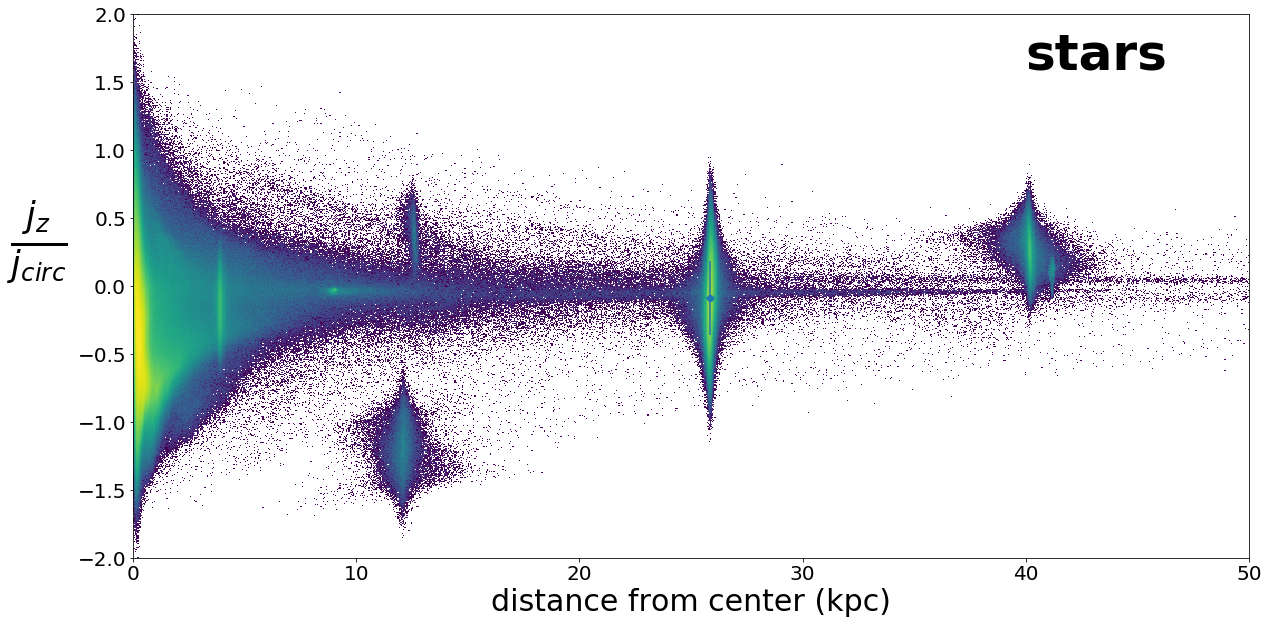

In [13]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
ax.hist2d(rd_s, ep_s, range = ([0, 50], [-2,2]), norm = mpl.colors.LogNorm(), cmap = mpl.cm.viridis, bins = 1000, alpha = 1.0)


avg_r, std_r = weighted_avg_and_std(anchor_rds, weights = anchor_mss)
avg_e, std_e = weighted_avg_and_std(anchor_eps, weights = anchor_mss)



ax.errorbar(avg_r, avg_e, xerr = std_r, yerr = std_e, marker = 'o')


ax.annotate('stars', (0.8, 0.9), xycoords = 'axes fraction', fontsize = 50, fontweight = 'bold')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('distance from center (kpc)', fontsize = 30)
ax.set_ylabel(r'$\frac{j_{z}}{j_{circ}}$', fontsize = 50, labelpad = 40, rotation = 0)




np.save('/Users/rsimons/Dropbox/rcs_foggie/outputs/nref11n_nref10f_selfshield_z6_anchors.npy', anchor_ids)




In [ ]:
anchor_ids = np.load('/Users/rsimons/Dropbox/rcs_foggie/outputs/nref11n_nref10f_selfshield_z6_anchors.npy')[()]

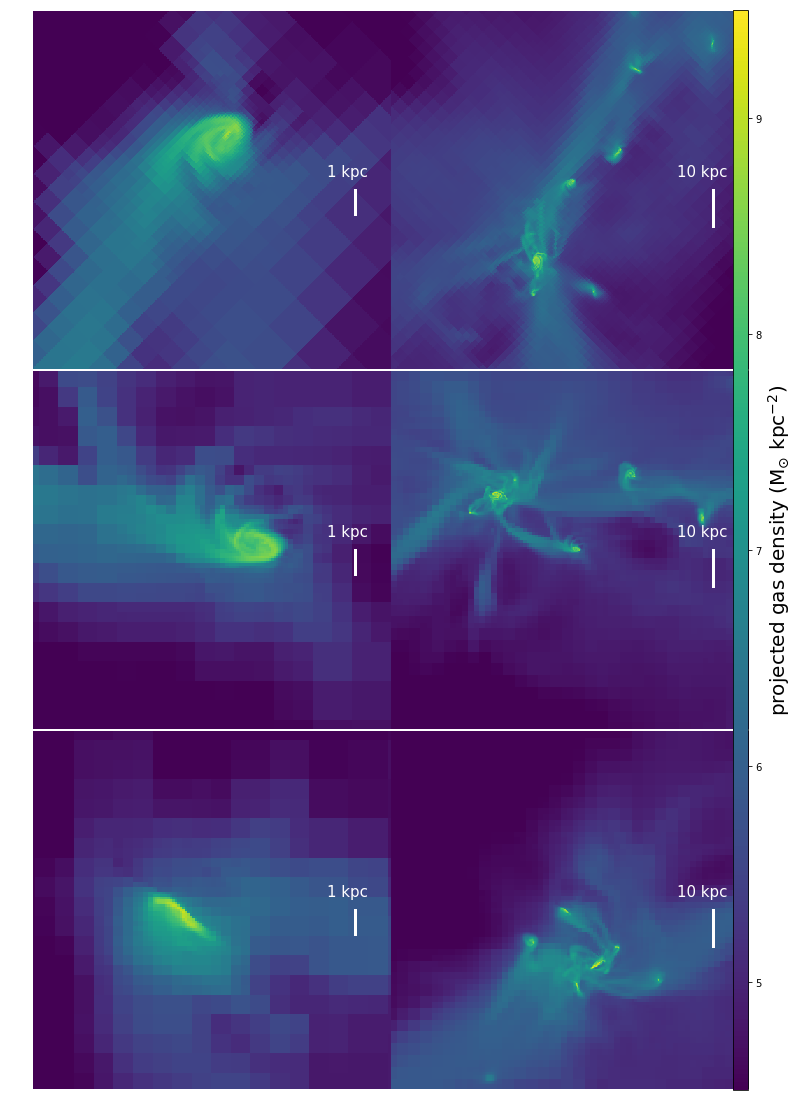

In [49]:
Ls = [[1,0,0], [0,1,0], [0, 0, 1]]

W1 = yt.YTArray([15, 15, 15], 'kpc')
W2 = yt.YTArray([100, 100, 100], 'kpc')

north_vector = [0,0.7,0.7]
N = 512


anchor_xs_box_avg = 26564.85890163585
anchor_ys_box_avg = 26236.47388230963
anchor_zs_box_avg = 27090.86022165454
cen = yt.YTArray([anchor_xs_box_avg, anchor_ys_box_avg, anchor_zs_box_avg], 'kpc')


fig, axes = plt.subplots(3,2, figsize = (10.8, 15))



for i in arange(3):
    L = Ls[i]
    image1 = yt.off_axis_projection(ds, cen, L, W1, N, ('gas', 'density'), north_vector =  north_vector)
    image2 = yt.off_axis_projection(ds, cen, L, W2, N, ('gas', 'density'), north_vector =  north_vector)


    image1 = image1.in_units('Msun * kpc**-2')
    image2 = image2.in_units('Msun * kpc**-2')

    im1 = axes[i, 0].imshow(np.log10(image1), vmin = 4.5, vmax = 9.5)
    im2 = axes[i, 1].imshow(np.log10(image2), vmin = 4.5, vmax = 9.5)


    bar_len_kpc = 1.
    bar_len_pix = 1.*N/W1[0].value * bar_len_kpc
    y_bar_start_pix = 0.5*N
    y_bar_end_pix = y_bar_start_pix + bar_len_pix
    x_bar_pix = 0.9*N
    axes[i, 0].plot([x_bar_pix, x_bar_pix], [y_bar_start_pix, y_bar_end_pix], color = 'white', linewidth = 3)
    axes[i, 0].annotate("%i kpc"%bar_len_kpc, (x_bar_pix-0.08*N, y_bar_start_pix- 0.04*N), color = 'white', fontsize = 15, rotation = 0)



    bar_len_kpc = 10
    bar_len_pix = 1.*N/W2[0].value * bar_len_kpc
    y_bar_start_pix = 0.5*N
    y_bar_end_pix = y_bar_start_pix + bar_len_pix
    x_bar_pix = 0.9*N
    axes[i, 1].plot([x_bar_pix, x_bar_pix], [y_bar_start_pix, y_bar_end_pix], color = 'white', linewidth = 3)
    axes[i, 1].annotate("%i kpc"%bar_len_kpc, (x_bar_pix-0.10*N, y_bar_start_pix- 0.04*N), color = 'white', fontsize = 15, rotation = 0)






for ax in axes.ravel():
    ax.axis('off')

cax = fig.add_axes([0.90, 0.0, 0.02, 1.0])
cbr = fig.colorbar(im1, cax=cax,orientation="vertical")

cbr.set_label('projected gas density (M$_{\odot}$ kpc$^{-2}$)', fontsize = 20)
fig.subplots_adjust(left = 0.0, right = 0.92, top =1.0, bottom = 0.0, hspace = 0.0, wspace = 0.0)

In [47]:
cbr.


AttributeError: 'Colorbar' object has no attribute 'ticks'